In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
import pylab as py
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
def get_html(url):
    """
    Fetch HTML content from the provided URL.
    
    Args:
        url (str): The webpage URL.
        
    Returns:
        str: Raw HTML content.
    """
    response = requests.get(url)
    response.raise_for_status()
    return response.text

def clean_pal_data(df):
    """
    Clean and select important features from pal data.
    
    Args:
        df (pd.DataFrame): Raw pal DataFrame.
        
    Returns:
        pd.DataFrame: Cleaned pal DataFrame.
    """
    selected = df[[
        'name', 'element', 'Hp', 'Attack', 'Defense',
        'Hp Bonus', 'Attack Bonus', 'Defense Bonus', 'Firepower'
    ]].copy()
    
    # Convert numeric fields
    for col in selected.columns[2:]:
        selected[col] = pd.to_numeric(selected[col], errors='coerce')
    
    return selected

def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

In [9]:
#Sets up url into html
url = "https://palworld.gg/pals"
html = requests.get(url)
soup = BeautifulSoup(html.text, "html.parser")
#Finds pals stats and adds into a list
tbl = []
for pal in soup.find_all(class_="pal"):
    lst = []
    base = "https://palworld.gg"
    if pal.select_one("a") == None:
        continue
    pal_url = base + pal.select_one("a").get("href")

    pal_html = requests.get(pal_url)
    lst.append(pal_url.split('/')[-1])
    pal_soup = BeautifulSoup(pal_html.text, "html.parser")
    items = pal_soup.find(class_="items")
    for item in items:
        lst.append(item.find(class_="value").text)
    tbl.append(lst)

#finds pals rarity and adds into a list
rarity_find = soup.find_all(class_='name')
rarity = []
for num in range(1, len(rarity_find), 2):
    rarity.append(rarity_find[num].text)
for num in range(0, len(tbl)):
    tbl[num].append(rarity[num])

#sets up pals stats and information into a dataframe
df = pd.DataFrame(tbl)
df.columns = ["name", "hp", "defense", "crafting speed", "melee attack", "shot attack", "price", "stamina", "support", "running speed", "sprinting speed", "slow walk speed", 'rarity']
df.set_index("name")
df.head()

,name,hp,defense,crafting speed,melee attack,shot attack,price,stamina,support,running speed,sprinting speed,slow walk speed,rarity
0,anubis,120,100,100,130,130,4960,100,100,800,1000,80,Epic
1,arsox,85,95,100,100,95,3520,120,100,700,1050,87,Common
2,astegon,100,125,100,100,125,8200,300,100,700,1100,100,Epic
3,azurmane,130,110,100,100,120,6680,220,100,900,1260,90,Rare
4,azurobe,110,100,100,70,100,5600,160,100,600,900,75,Rare


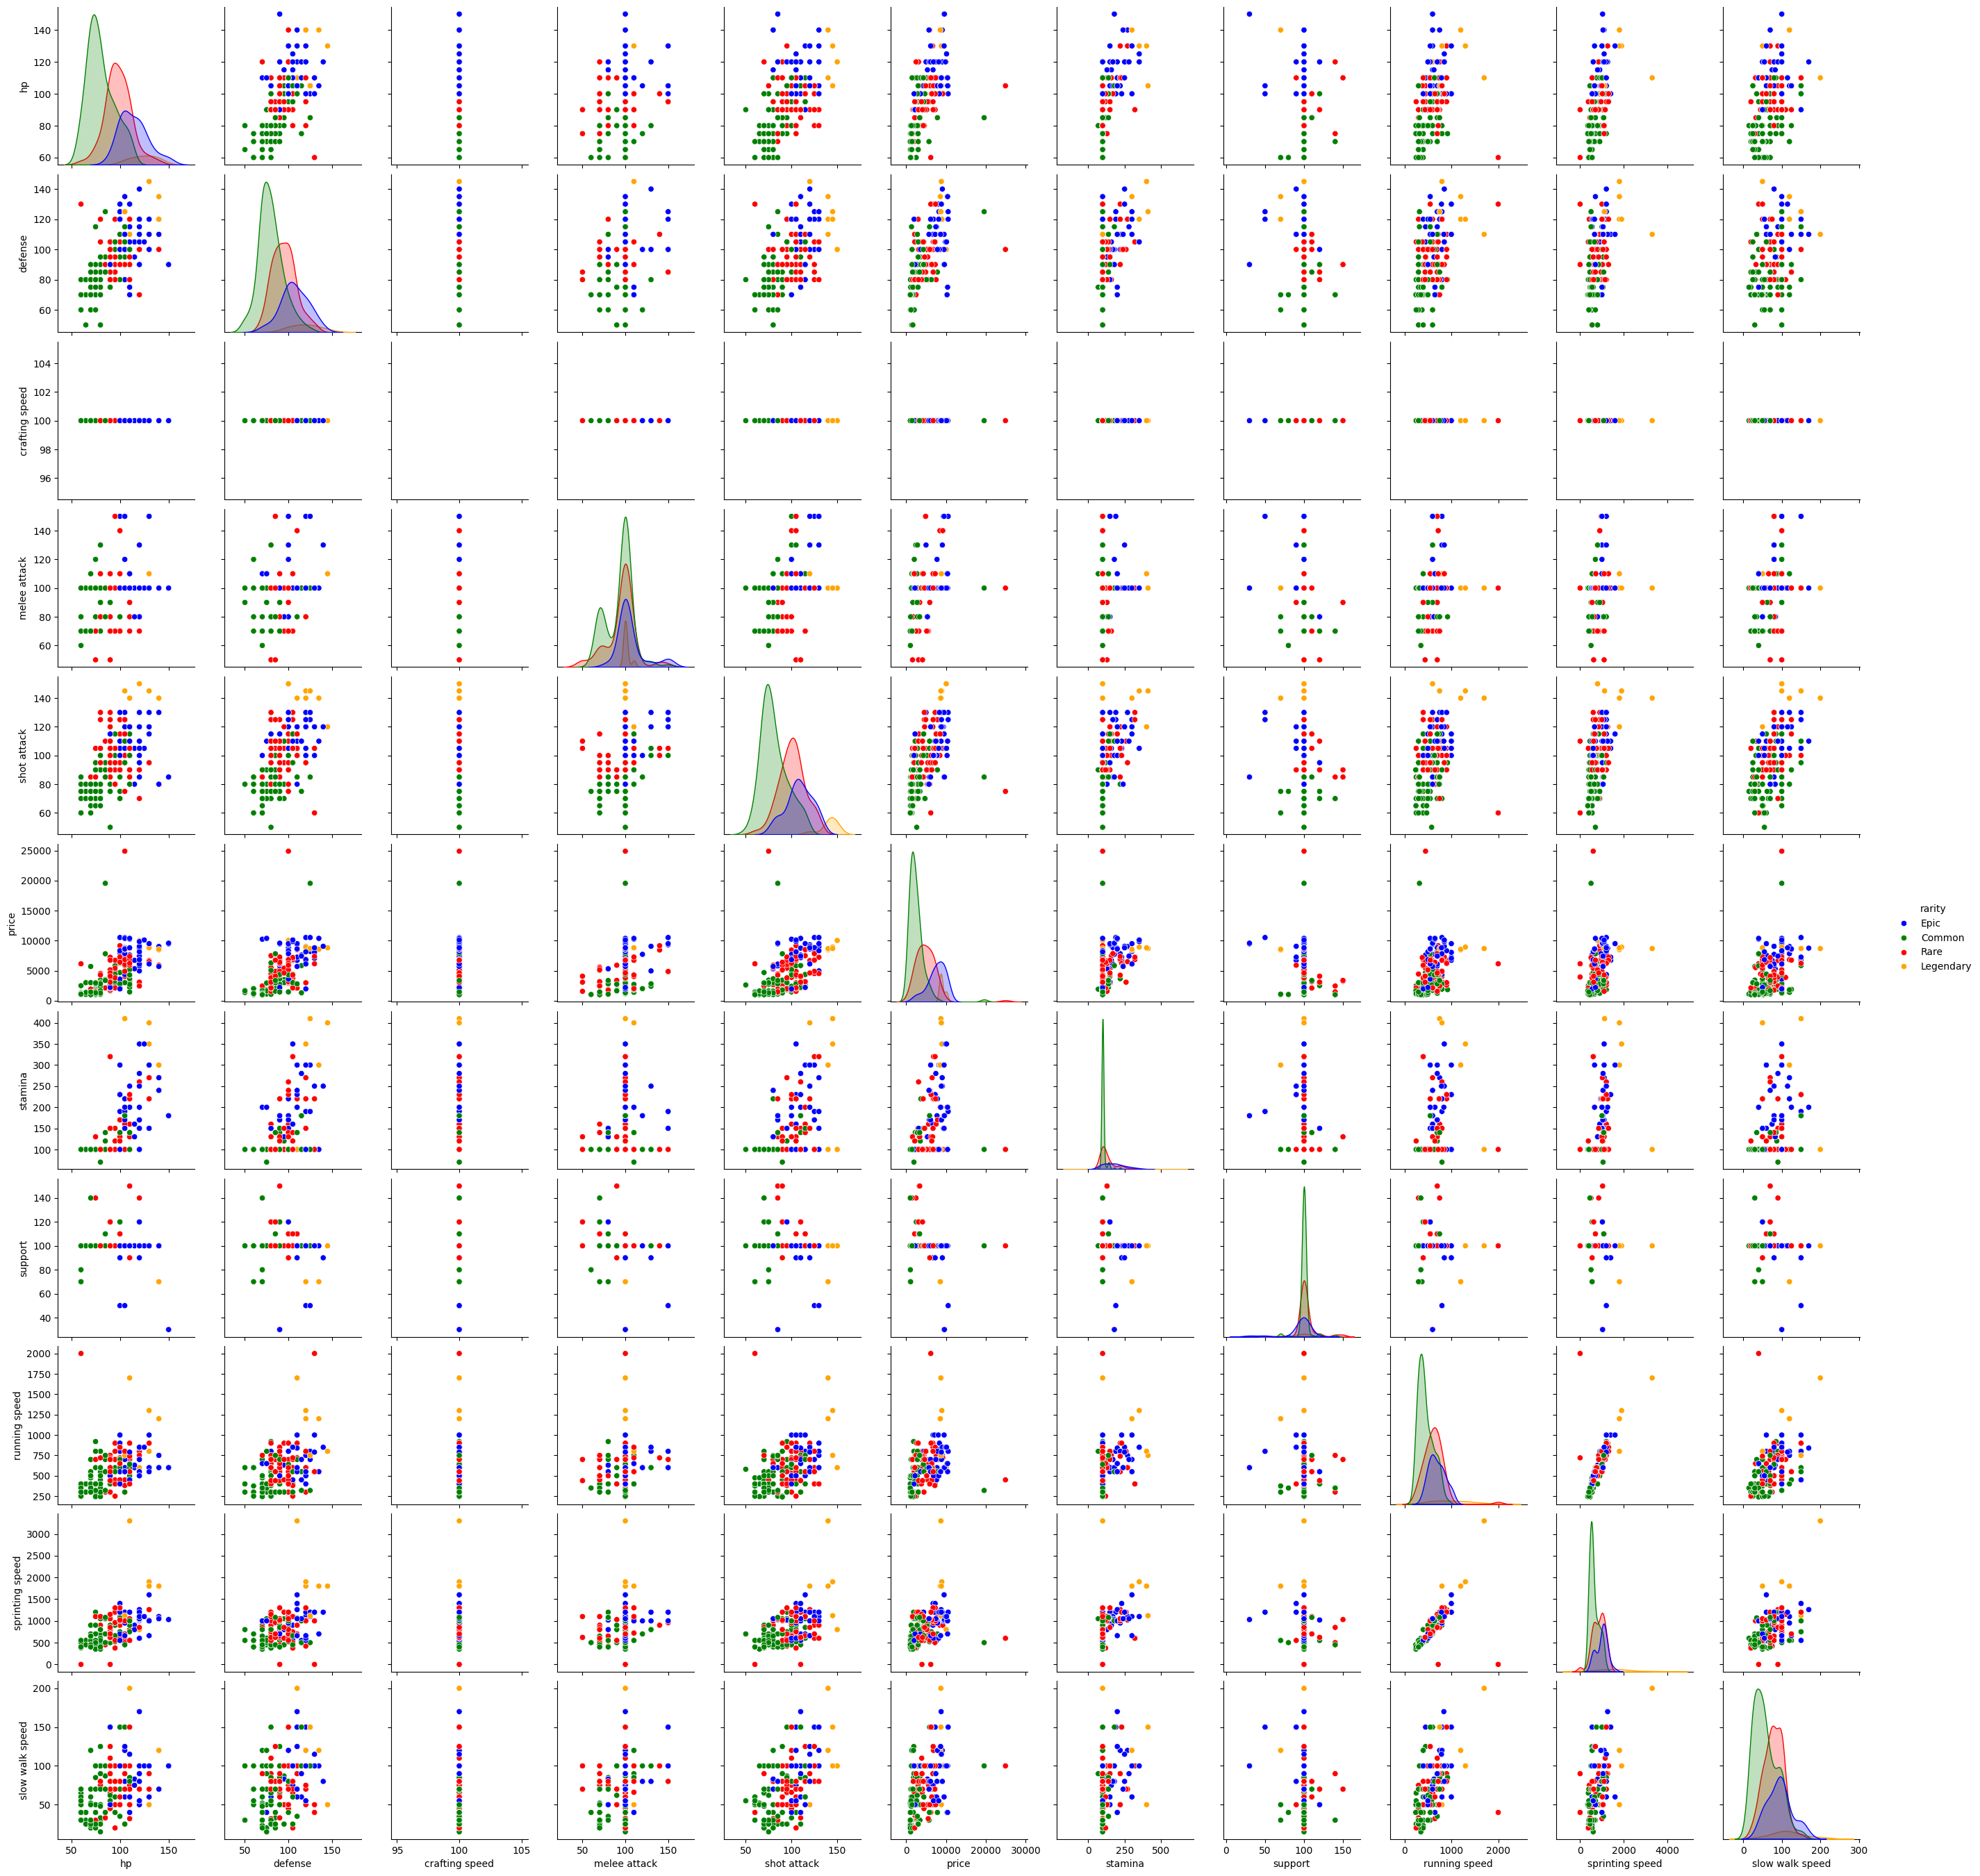

In [4]:
#just so I don't have to rerun the stuff above for a dataframe
df_pal_stats = df

#grabs the columns with numeric values
numeric_cols = df_pal_stats.columns[1:-1].tolist()

#changes the values that were strings into floats
for col in numeric_cols:
    df_pal_stats[col] = df_pal_stats[col].astype(float)

#plots the rarity to the x features
custom_colors = {'Common': 'Green', 'Rare': 'Red', 'Epic': 'Blue', 'Legendary': 'Orange'}
sns.pairplot(df_pal_stats.loc[:, ['hp', 'defense', 'crafting speed', 'melee attack', 'rarity', 'shot attack', 'price', 'stamina', 'support', 'running speed', 'sprinting speed', 'slow walk speed']], hue='rarity', palette = custom_colors)

In [5]:
def model(df, x_feat_list, max_depth = 3, n_splits = 5):
    """ creates a random forest model and then prints the:
        - accuracy
        - confusion matrix
        - feature importance graph
        - decision tree created with the 5 most important features
    
    Args:
        df (dataframe): the dataframe to pull values from
        x_feat_list (list of strings): list of feature names
        max_depth (int) = max depth of the tree
        n_splits (int) = how many splits for the stratified kfold
    """

    from sklearn.metrics import accuracy_score
    import copy
    kfold = StratifiedKFold(n_splits=n_splits)
    max_depth = max_depth
    
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, 'tier'].values
    
    y_pred = np.empty_like(y)
    
    rf_clf = RandomForestClassifier(max_depth = max_depth, n_estimators = 1000)
    
    for train_idx, test_idx in kfold.split(x, y):
        x_test = x[test_idx,:]
        x_train = x[train_idx,:]
        y_true_train = y[train_idx]
    
        rf_clf.fit(x_train, y_true_train)
        y_pred[test_idx] = rf_clf.predict(x_test)
    print('Accuracy of random forest: ' , accuracy_score(y, y_pred))
    
    plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = 10)
    y_feat_list = np.array(['s', 'a', 'b', 'c', 'd'])
    conf_mat = confusion_matrix(y_true = y, y_pred = y_pred)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = y_feat_list)
    conf_mat_disp.plot()
    plt.grid(False)
    
    
    importances = rf_clf.feature_importances_
    indices = importances.argsort()[::-1]
    top5feat= [x_feat_list[i] for i in indices[:5]]
    
    kfold = StratifiedKFold(n_splits=7)
    
    x_feat_list = top5feat
    max_depth = max_depth
    
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, 'tier'].values
    
    y_pred = copy.deepcopy(y)
    
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    
    for train_idx, test_idx in kfold.split(x, y):
        x_test = x[test_idx,:]
        x_train = x[train_idx,:]
        y_true_train = y[train_idx]
    
        dec_tree_clf.fit(x_train, y_true_train)
        y_pred[test_idx] = dec_tree_clf.predict(x_test)
    
    from sklearn.metrics import accuracy_score
    print('Accuracy score of decision tree based on the 5 most important features from the random forst:' ,accuracy_score(y, y_pred))
    
    plt.figure()
    plt.gcf().set_size_inches(15, 10)
    
    tree.plot_tree(dec_tree_clf, 
                  feature_names = x_feat_list, 
                  class_names = dec_tree_clf.classes_);
    pass


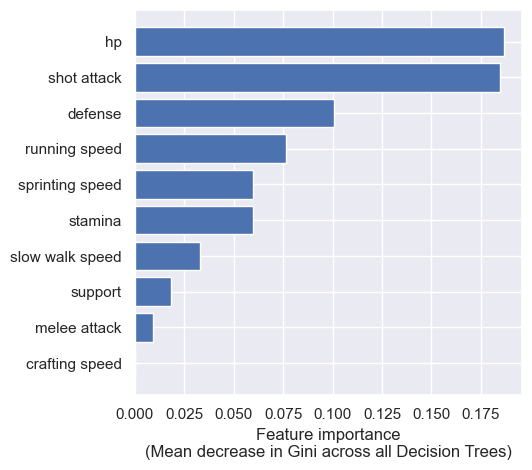

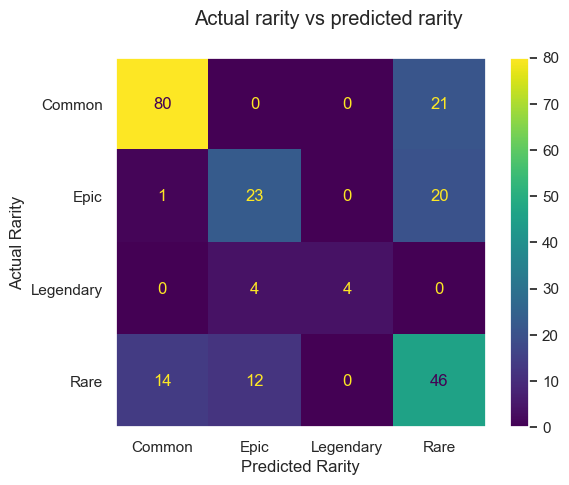

3


[Text(0.5, 0.875, 'hp <= 87.5\ngini = 0.657\nsamples = 225\nvalue = [101, 44, 8, 72]'),
 Text(0.25, 0.625, 'shot attack <= 102.5\ngini = 0.198\nsamples = 81\nvalue = [72, 0, 0, 9]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'defense <= 117.5\ngini = 0.101\nsamples = 75\nvalue = [71, 0, 0, 4]'),
 Text(0.0625, 0.125, 'gini = 0.054\nsamples = 72\nvalue = [70, 0, 0, 2]'),
 Text(0.1875, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [1, 0, 0, 2]'),
 Text(0.375, 0.375, 'shot attack <= 107.5\ngini = 0.278\nsamples = 6\nvalue = [1, 0, 0, 5]'),
 Text(0.3125, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [1, 0, 0, 2]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3]'),
 Text(0.75, 0.625, 'hp <= 112.5\ngini = 0.672\nsamples = 144\nvalue = [29, 44, 8, 63]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'defense <= 107.5\ngini = 0.625\nsamples = 111\nvalue = [29, 23, 2, 57]'),
 Text(0.5625, 0.125, 'gini = 0.567\nsamples = 88\nvalue = [27.0, 11.0, 0.0, 50.0]'),
 Text(0.6

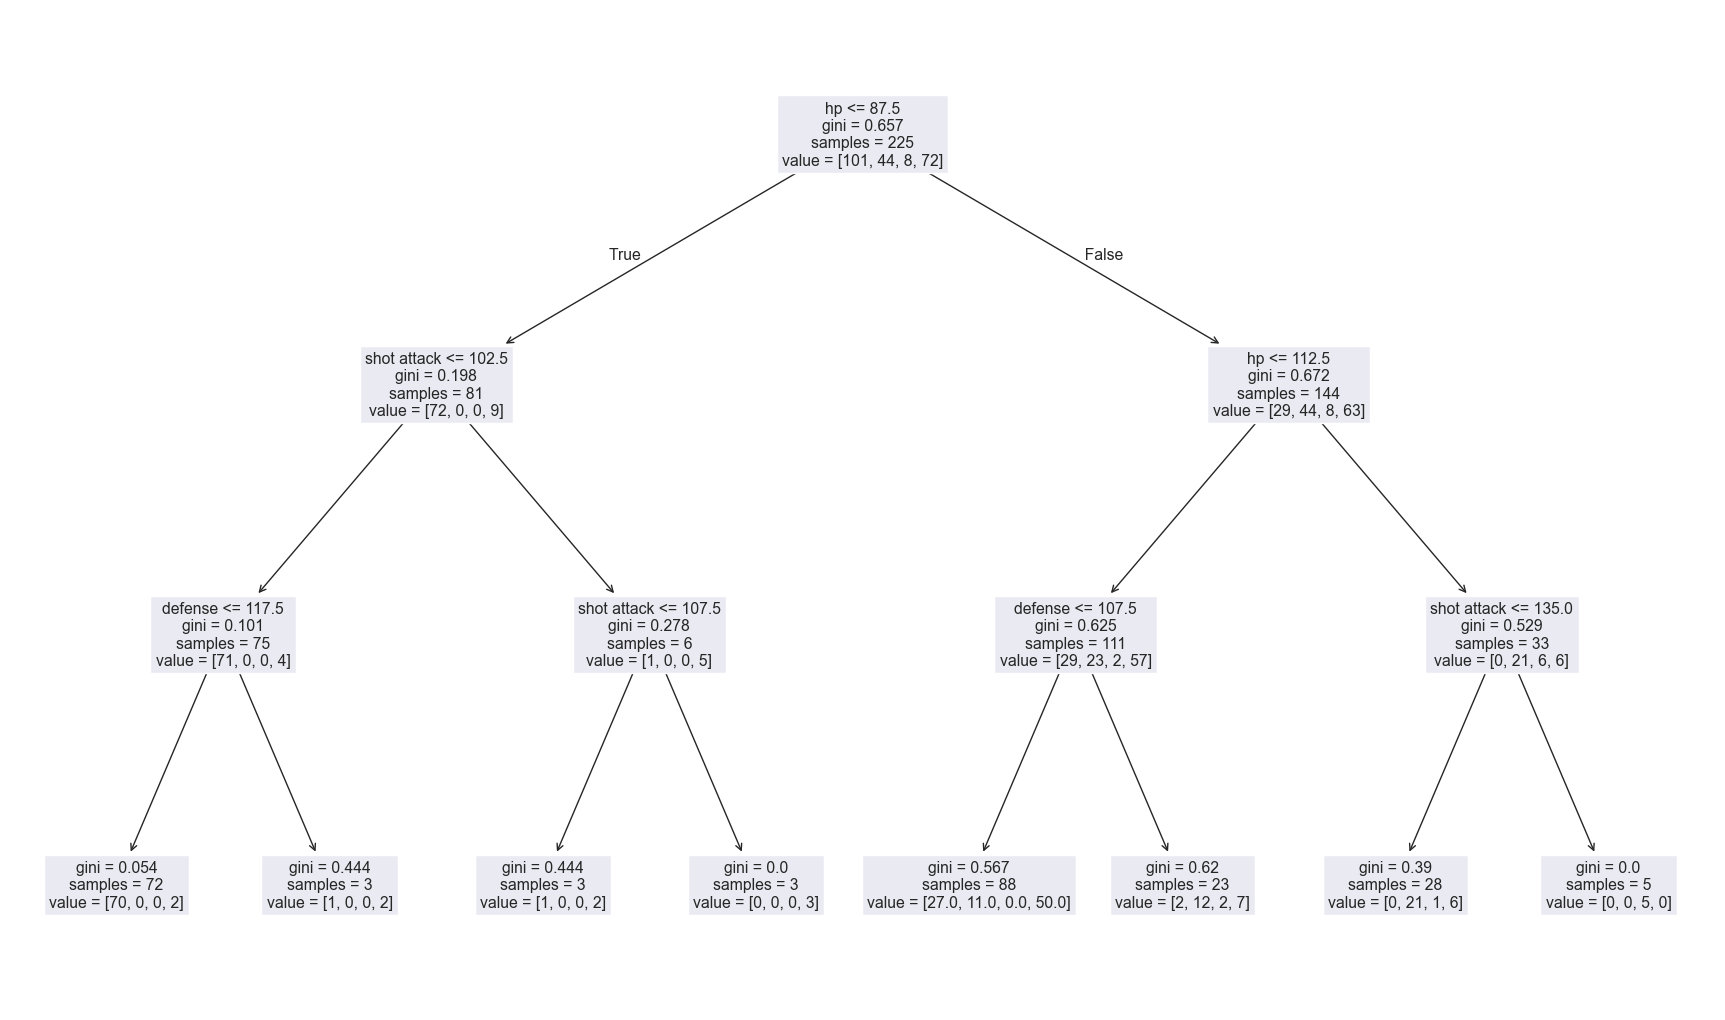

In [6]:
x_feat_list = list(df_pal_stats)[1:-1]

x = df_pal_stats.loc[:, x_feat_list].values
y = df_pal_stats.loc[:, 'rarity'].values

#Find the best depth
n_splits = 8
skfold = StratifiedKFold(n_splits = n_splits)

y_pred = np.empty_like(y)

depths = range(2, 12)
best_accuracy = 0
best_depth = 2
for depth in depths:
    rf_clf = RandomForestClassifier(max_depth = depth, n_estimators = 1000)
    for train_idx, test_idx in skfold.split(x, y):

        x_train = x[train_idx,:]
        y_train = y[train_idx]
        x_test = x[test_idx,:]

        rf_clf.fit(x_train, y_train)
        y_pred[test_idx] = rf_clf.predict(x_test)

    current_accuracy = accuracy_score(y, y_pred)
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_depth = depth

# Makes the randomforestclassifier with the most accuracy
rf_clf = RandomForestClassifier(max_depth = best_depth, n_estimators = 1000)

y_pred = np.empty_like(y)
y_pred_final = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):

    x_train = x[train_idx,:]
    y_train = y[train_idx]
    x_test = x[test_idx,:]

    rf_clf.fit(x_train, y_train)
    y_pred_final[test_idx] = rf_clf.predict(x_test)

sns.set()
plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = 10)

labels = ['Common', 'Epic', 'Legendary', 'Rare']
cm = confusion_matrix(y, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.grid(False)
plt.xlabel('Predicted Rarity')
plt.ylabel('Actual Rarity')
plt.suptitle('Actual rarity vs predicted rarity')
plt.show()

x_feat_list = ['hp', 'shot attack', 'defense', 'running speed']

x = df_pal_stats.loc[:, x_feat_list].values
y = df_pal_stats.loc[:, 'rarity'].values

print(best_depth)
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=best_depth)
dec_tree_clf = dec_tree_clf.fit(x, y)

plt.figure()
plt.gcf().set_size_inches(22, 13)
tree.plot_tree(dec_tree_clf, feature_names=x_feat_list)